# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [ ]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [ ]:
# Download the data
if not os.path.exists('/content/aerialseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/aerialseq.npy -O /content/aerialseq.npy
if not os.path.exists('/content/antseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/antseq.npy -O /content/antseq.npy

--2025-09-26 16:17:00--  https://www.cs.cmu.edu/~deva/data/aerialseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92160128 (88M)
Saving to: ‘/content/aerialseq.npy’

/content/aerialseq. 100%[===================>]  87.89M  9.51MB/s    in 8.2s    

2025-09-26 16:17:08 (10.7 MB/s) - ‘/content/aerialseq.npy’ saved [92160128/92160128]

--2025-09-26 16:17:08--  https://www.cs.cmu.edu/~deva/data/antseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M)
Saving to: ‘/content/antseq.npy’

/content/antseq.npy 100%[===================>]  62.50M  12.0MB/s    in 5.1s    

2025-09-26 16:17:14 (12.3 MB/s) - ‘/content/antseq.npy’ saved [65536128/65536128]



# Q4: Efficient Tracking

## Q4.1: Inverse Composition (15 points)

In [ ]:
from scipy.interpolate import RectBivariateSpline
import cv2

def InverseCompositionAffine(It, It1, threshold, num_iters):
    """
    :param It        : (H, W), current image
    :param It1       : (H, W), next image
    :param threshold : (float), if the length of dp < threshold, terminate the optimization
    :param num_iters : (int), number of iterations for running the optimization

    :return: M       : (2, 3) The affine transform matrix
    """
    # Initial M
    M = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]])

    # ===== your code here! =====
    H, W = It.shape

    x, y = np.meshgrid(np.arange(W), np.arange(H))
    x, y = x.flatten(), y.flatten()
    ones = np.ones_like(x)
    coords = np.vstack([x, y, ones])

    spline_It = RectBivariateSpline(np.arange(H), np.arange(W), It)
    spline_It1 = RectBivariateSpline(np.arange(H), np.arange(W), It1)
    Ix = spline_It.ev(y, x, dx=0, dy=1).flatten()
    Iy = spline_It.ev(y, x, dx=1, dy=0).flatten()

    A = np.vstack([
        Ix * x, Ix * y, Ix,
        Iy * x, Iy * y, Iy
    ]).T

    H_inv = np.linalg.inv(A.T @ A)

    It_flat = It.flatten()

    for i in range(num_iters):
        It1_warped = cv2.warpAffine(It1, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
        It1_warped_flat = It1_warped.flatten()

        warp_coords = M @ coords
        x_warp, y_warp = warp_coords[0, :], warp_coords[1, :]

        out_of_bounds = (x_warp < 0) | (x_warp >= W) | (y_warp < 0) | (y_warp >= H)
        It_warped = spline_It.ev(y_warp, x_warp)
        It1_warped = spline_It1.ev(y_warp, x_warp)
        error = (It_flat - It1_warped_flat).reshape(-1, 1)
        error[out_of_bounds] = 0

        dp = H_inv @ (A.T @ error)
        dp = dp.flatten()

        delta_M = np.array([
            [1 + dp[0], dp[1], dp[2]],
            [dp[3], 1 + dp[4], dp[5]],
            [0, 0, 1]
        ])

        M_full = np.vstack([M, [0, 0, 1]])
        M = (M_full @ np.linalg.inv(delta_M))[:2, :]

        if np.linalg.norm(dp) < threshold:
            break


    # ===== End of code =====
    return M

## Debug Q4.1



Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. When you warp the source frame using the obtained transformation matrix, it should resemble the target frame.

Text(0.5, 1.0, 'Warped Source image')

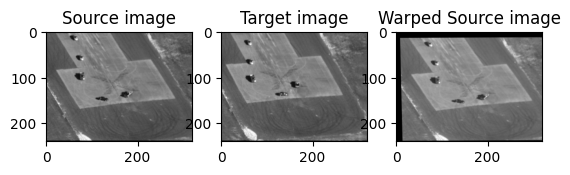

In [ ]:
import cv2

num_iters = 100
threshold = 0.02
seq = np.load("/content/aerialseq.npy")
It = seq[:,:,0]
It1 = seq[:,:,10]

# Source frame
plt.figure()
plt.subplot(1,3,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')

# Target frame
plt.subplot(1,3,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image')

# Warped source frame
M = InverseCompositionAffine(It, It1, threshold, num_iters)
warped_It = cv2.warpAffine(It, M,(It.shape[1],It.shape[0]))
plt.subplot(1,3,3)
plt.imshow(warped_It, cmap='gray')
plt.title('Warped Source image')

## Q4.2 Tracking with Inverse Composition (10 points)

Re-use your impplementation in Q3.2 for subtract dominant motion. Just make sure to use InverseCompositionAffine within.

In [ ]:
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation
from scipy.ndimage import affine_transform
import cv2
def SubtractDominantMotion(It, It1, num_iters, threshold, tolerance):
    """
    Returns a mask of moving objects by subtracting dominant global motion.
    """
    H, W = It.shape

    M = InverseCompositionAffine(It, It1, threshold, num_iters)

    # warped_It1 = affine_transform(It1, M, mode='nearest')
    # valid_mask = affine_transform(np.ones_like(It1), M, mode='nearest')
    warped_It1 = cv2.warpAffine(It1, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    valid_mask = cv2.warpAffine(np.ones_like(It1), M, (W, H), flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

    diff = np.abs(It - warped_It1) * valid_mask
    mask = diff > tolerance

    mask = binary_dilation(mask, iterations=2)
    mask = binary_erosion(mask, iterations=2)

    return mask

Re-use your implementation in Q3.3 for sequence tracking.

In [ ]:
from tqdm import tqdm

def TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance):
    """
    :param seq       : (H, W, T), sequence of frames
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, if the length of dp < threshold, terminate the optimization
    :param tolerance : (float), binary threshold of intensity difference when computing the mask
    :return: masks   : (T, 4) moved objects for each frame
    """
    H, W, N = seq.shape

    It = seq[:, :, 0]
    masks = []

    # ===== your code here! =====
    for i in tqdm(range(1, seq.shape[2])):
        It1 = seq[:, :, i]
        mask = SubtractDominantMotion(It, It1, num_iters, threshold, tolerance)
        masks.append(mask)


    # ===== End of code =====
    masks = np.stack(masks, axis=2)
    return masks

Track the ant sequence with inverse composition method.


In [ ]:
seq = np.load("/content/antseq.npy")

# NOTE: feel free to play with these parameters
#dilation and erosion iteration = 1
num_iters = 1000
threshold = 0.02
tolerance = 0.2

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAnt Sequence takes %f seconds' % (toc - tic))

100%|██████████| 124/124 [00:12<00:00, 10.29it/s]



Ant Sequence takes 12.105574 seconds


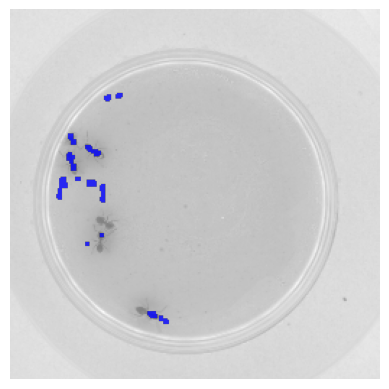

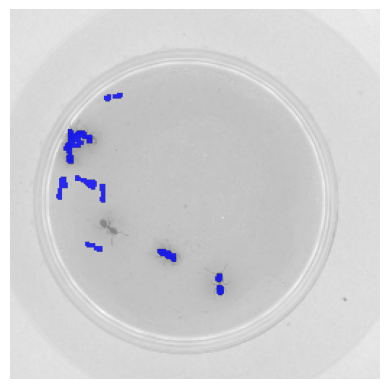

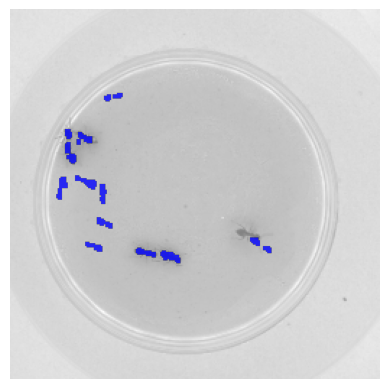

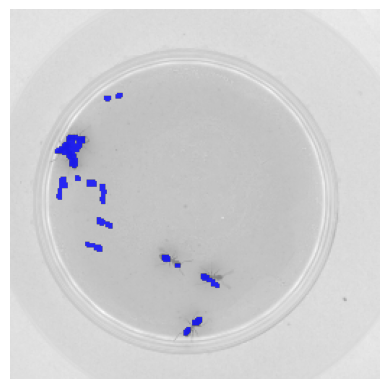

In [ ]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')


Track the aerial sequence with inverse composition method.


In [ ]:
seq = np.load("/content/aerialseq.npy")

# NOTE: feel free to play with these parameters
#dilation and erosion iteration = 2
num_iters = 1000
threshold = 1.0
tolerance = 0.3

tic = time.time()
masks = TrackSequenceAffineMotion(seq, num_iters, threshold, tolerance)
toc = time.time()
print('\nAerial Sequence takes %f seconds' % (toc - tic))

100%|██████████| 149/149 [00:43<00:00,  3.42it/s]


Aerial Sequence takes 43.708784 seconds


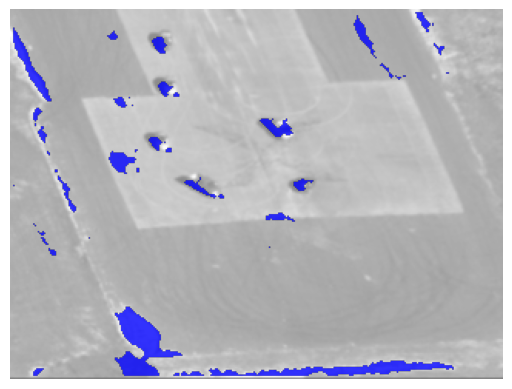

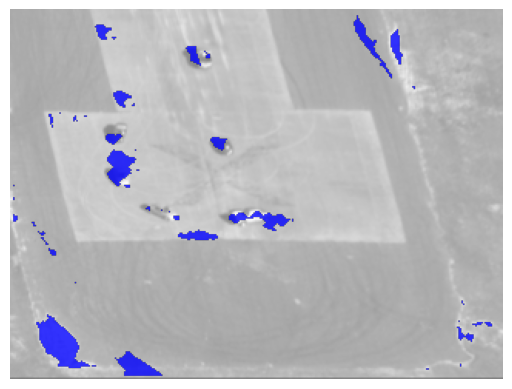

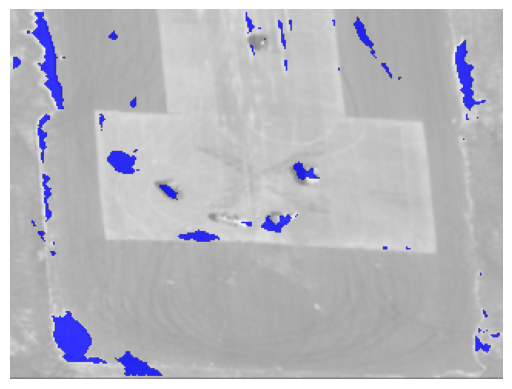

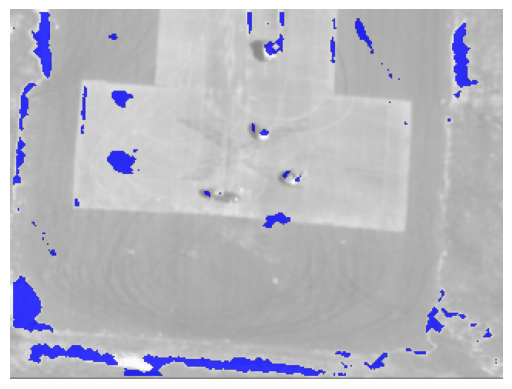

In [ ]:
frames_to_save = [29, 59, 89, 119]

# TODO: visualize
for idx in frames_to_save:
    frame = seq[:, :, idx]
    mask = masks[:, :, idx]

    plt.figure()
    plt.imshow(frame, cmap="gray", alpha=0.5)
    plt.imshow(np.ma.masked_where(np.invert(mask), mask), cmap='winter', alpha=0.8)
    plt.axis('off')

## Q4.2.1 Compare the runtime of the algorithm using inverse composition (as described in this section) with its runtime without inverse composition (as detailed in the previous section) in the context of the ant and aerial sequences:
===== your answer here! =====  
Inverse composition Results:  
Ant Sequence takes 8.863341 seconds  
Aerial Sequence takes 43.708784 seconds

Without Inverse Composition:  
Ant Sequence takes 13.120779  seconds  
Aerial Sequence takes 1813.514410 seconds


===== end of your answer ====

## Q4.2.2 In your own words, please describe briefly why the inverse compositional approach is more computationally efficient than the classical approach:
===== your answer here! =====  

We see that the inverse compositional approach is more computationally efficient than the classical approach. This is because in classical approach, we were computing the gradients, A matrix and hessian in each iteration. In inverse compositional approach, the gradients, A matrix and the hessian are computed once on the fixed template image and reused for all iterations making it faster. Only the inverse of hessian needs to be computed in each iteration. The difference is not very huge in my implementation as I am using opencv functions in classical approach to run on colab. Classical approach from scratch was taking up approximately 2hrs for the aerial sequence hence had to migrate to opencv and numpy functions that use cpp wrapper and are relatively faster. Also in case of ant sequence the camera movement is not as much as in aerial sequence. Hence the time difference is less in ant sequence as compared to aerial sequence.  

===== end of your answer ====